In [1]:
import os
import pickle as pk
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from helper_utils.utils import *

In [2]:
# Load data

data_directory = "processed_data"
data_filename_base = "X_top300_201801_201912_30_m_final"
data_filename_ext = ".npz"
data_filename = data_filename_base+data_filename_ext

data = {}
with np.load(os.path.join(data_directory, data_filename)) as npz_loader:
    for key in npz_loader.files:
        print("{}: {}".format(key, npz_loader[key].shape))
        data[key] = npz_loader[key]

X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_test = data["X_test"]
y_test = data["y_test"]


input_shape = tuple(list(X_train.shape)[1:])
output_shape = tuple(list(y_train.shape)[1:])
input_dims = np.product(input_shape)
output_dims = np.product(output_shape)

num_nodes, num_steps, input_features = input_shape
_, _, output_features = output_shape

X_train: (17725, 300, 10, 4)
y_train: (17725, 300, 10, 2)
X_val: (3545, 300, 10, 4)
y_val: (3545, 300, 10, 2)
X_test: (7090, 300, 10, 4)
y_test: (7090, 300, 10, 2)


In [3]:
from models.fnn import FNN
from models.linear import LinearRegressor
from models.fclstm import FCLSTM
from models.stgcn import STGCN
from models.wavenet import GraphWaveNet

In [21]:
model_params = {  'num_layers': 2,
                  'units_per_layer':256,
                  'num_nodes': num_nodes,
                  'num_steps': num_steps,
                  'input_features': input_features,
                  'output_features': output_features,
                  'l2_reg': 0.00}

training_specs = {'model_name': 'FNN',
                  'save_model': True,
                  'save_model_history': True,
                  'batch_size': 64,
                  'max_epochs': 50,
                  'patience': 10,
                  'loss_type': 'mae',
                  'learning_rate': 1e-3}

BATCH_SIZE = training_specs['batch_size']
MAX_EPOCHS = training_specs['max_epochs']
PATIENCE = training_specs['patience']
LOSS_TYPE = training_specs['loss_type']
LEARNING_RATE = training_specs['learning_rate']

callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

In [8]:
tf.__version__

'2.8.0'

In [9]:
model = FNN(model_params)

model.compile(loss=LOSS_TYPE, optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
print(model(X_train[:32]).shape)
model.summary()

(32, 300, 10, 2)
Model: "fnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  10496     
                                                                 
 dense_4 (Dense)             multiple                  65792     
                                                                 
 dense_5 (Dense)             multiple                  5140      
                                                                 
 reshape_3 (Reshape)         multiple                  0         
                                                                 
Total params: 81,428
Trainable params: 81,428
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(x=X_train, y=y_train, shuffle=True,
                    batch_size=BATCH_SIZE, epochs=MAX_EPOCHS,
                    validation_data=(X_val,y_val),
                    callbacks=[callback_es])

Epoch 1/2


2022-04-24 08:22:16.963651: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/277 [..............................] - ETA: 1:45 - loss: 1.4974

2022-04-24 08:22:17.190502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


275/277 [============================>.] - ETA: 0s - loss: 1.0096

2022-04-24 08:22:20.932209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


277/277 [==============================] - 4s 15ms/step - loss: 1.0104 - val_loss: 0.7329
Epoch 2/2
277/277 [==============================] - 4s 14ms/step - loss: 0.9559 - val_loss: 0.7300


222/222 [==============================] - 2s 7ms/step - loss: 1.3696
FNN test Loss =  1.3696495294570923


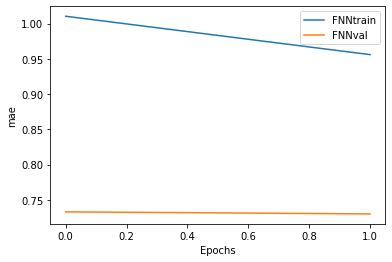

In [11]:
# EVALUATION
plt.figure()
plt.xlabel("Epochs")
plt.ylabel(LOSS_TYPE)
plt.plot(history.history['loss'],label=training_specs['model_name']+'train')
plt.plot(history.history['val_loss'],label=training_specs['model_name']+'val')
plt.legend()

print(training_specs['model_name']+" test Loss = ", model.evaluate(X_test,y_test))

In [17]:
predictions = model.predict(X_test)
ground_truth = y_test

In [20]:
model_store_directory = "stored_models"
run_info_store_directory = "stored_models"

if training_specs['save_model']:
    model_store_filename = "_".join([training_specs['model_name'], "model"])
    model_store_filepath = os.path.join(model_store_directory, model_store_filename)
    model.save(model_store_filepath, save_format="tf")

if training_specs['save_model_history']:
    run_info = {}
    run_info["train_test_path"] = data_filename
    run_info["history"] = history.history
    run_info["predictions"] = predictions

    run_info_store_filename = "_".join([training_specs['model_name'], "run_info"]) + ".pk"
    run_info_store_filepath = os.path.join(run_info_store_directory, run_info_store_filename)
    pk.dump(run_info, open(run_info_store_filepath, "wb"))

INFO:tensorflow:Assets written to: stored_models/FNN_model/assets


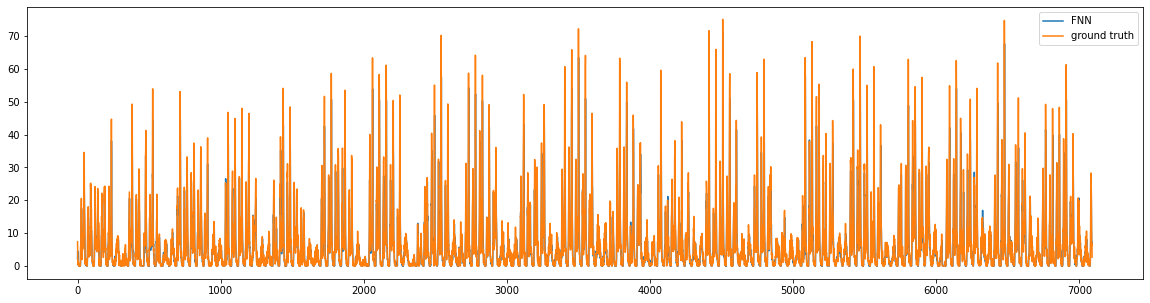

In [19]:
station = 0
horizon = 0

horizon_predictions = seq_from_windows(predictions, horizon=horizon)
horizon_ground_truth = seq_from_windows(y_test, horizon=horizon)

plt.figure(figsize=(20,5))
plt.plot(horizon_predictions[station,:,0],label=training_specs['model_name'])
plt.plot(horizon_ground_truth[station,:,0],label='ground truth')
plt.legend()